## Environmental Source Apportionment Toolkit (ESAT) Simulator


In [1]:
# Notebook imports
import os
import sys
import json
import numpy as np
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Code Imports

In [2]:
from esat.data.datahandler import DataHandler
from esat.model.sa import SA
from esat.model.batch_sa import BatchSA
from esat.data.analysis import ModelAnalysis, BatchAnalysis
from esat.metrics import q_loss, qr_loss
from esat_eval.simulator import Simulator

#### Synthetic Dataset

Generate a synthetic dataset where the factor profiles and contributions are pre-determined for model output analysis.

In [41]:
# Synethic dataset parameters
seed = 42
syn_factors = 6
syn_features = 50
syn_samples = 200
outliers = FalseS
outlier_p = 0.00
outlier_mag = 2
contribution_max = 10
noise_mean = 0.1
noise_var = 0.02
uncertainty_mean = 0.05
uncertainty_var = 0.01

In [42]:
simulator = Simulator(seed=seed,
                      factors_n=syn_factors,
                      features_n=syn_features,
                      samples_n=syn_samples,
                      outliers=outliers,
                      outlier_p=outlier_p,
                      outlier_mag=outlier_mag,
                      contribution_max=contribution_max,
                      noise_mean=noise_mean,
                      noise_var=noise_var,
                      uncertainty_mean=uncertainty_mean,
                      uncertainty_var=uncertainty_var
                     )

# my_profile = np.ones(shape=(syn_factors, syn_features))
# simulator.generate_profiles(profiles=my_profile)

18-Apr-24 15:22:56 - Synthetic profiles generated
18-Apr-24 15:22:56 - Synthetic data generated
18-Apr-24 15:22:56 - Synthetic uncertainty data generated
18-Apr-24 15:22:56 - Synthetic dataframes completed
18-Apr-24 15:22:56 - Synthetic source apportionment instance created.


#### Input Parameters

In [43]:
index_col = "Date"                  # the index of the input/uncertainty datasets
factors = syn_factors               # the number of factors
method = "ls-nmf"                   # "ls-nmf", "ws-nmf"
models = 20                         # the number of models to train
init_method = "col_means"           # default is column means "col_means", "kmeans", "cmeans"
init_norm = True                    # if init_method=kmeans or cmeans, normalize the data prior to clustering.
seed = 42                           # random seed for initialization
max_iterations = 20000              # the maximum number of iterations for fitting a model
converge_delta = 0.1                # convergence criteria for the change in loss, Q
converge_n = 10                     # convergence criteria for the number of steps where the loss changes by less than converge_delta
verbose = True                      # adds more verbosity to the algorithm workflow on execution.
optimized = True                    # use the Rust code if possible
parallel = True                     # execute the model training in parallel, multiple models at the same time

#### Load Data
Assign the processed data and uncertainty datasets to the variables V and U. These steps will be simplified/streamlined in a future version of the code.

In [44]:
syn_input_df, syn_uncertainty_df = simulator.get_data()

In [45]:
data_handler = DataHandler.load_dataframe(input_df=syn_input_df, uncertainty_df=syn_uncertainty_df)
V, U = data_handler.get_data()

#### Input/Uncertainty Data Metrics and Visualizations

In [46]:
# Show the input data metrics, including signal to noise ratio of the data and uncertainty
data_handler.metrics

Category        S/N       Min       25th       50th       75th  \
Feature 1    Strong  19.406684  0.043349   2.060621   3.289616   4.740097   
Feature 2    Strong  19.693644  0.021637   0.300228   0.422110   0.569747   
Feature 3    Strong  19.533163  4.357276  11.561915  14.548122  17.572479   
Feature 4    Strong  20.068199  0.101010   1.506524   3.077280   4.996709   
Feature 5    Strong  19.463063  3.828217  10.898285  14.220789  18.065620   
Feature 6    Strong  19.470053  0.008567   1.214123   2.583729   3.991605   
Feature 7    Strong  19.752655  1.769062   7.113961   9.134100  11.151358   
Feature 8    Strong  20.391123  0.374401   3.115145   4.247374   5.410878   
Feature 9    Strong  20.119935  0.871720   8.971035  11.634946  15.203440   
Feature 10   Strong  19.659481  1.963082  11.096369  14.698290  18.096944   
Feature 11   Strong  19.681934  2.211797  11.711214  14.487868  17.981004   
Feature 12   Strong  19.356396  2.344799   8.060364  10.333935  12.529165   
Feature 13   Strong  19.802132  0.612091   5.773684   8.585084  10.824972   
Feature 14   Strong  19.813356  0.931417  10.651865  14.091024  17.757507   
Feature 15   Strong  19.364295  1.328678   9.253351  11.737905  14.220781   
Feature 16   Strong  19.491434  2.902768   9.601535  12.352157  14.854266   
Feature 17   Strong  20.298920  0.432344   7.054053   9.774120  12.265505   
Feature 18   Strong  20.084078  1.805313  12.769289  16.431928  19.579891   
Feature 19   Strong  19.538391  0.038657   2.147359   4.638816   6.811842   
Feature 20   Strong  20.141932  2.316904  13.359952  17.373351  20.352666   
Feature 21   Strong  20.479681  0.004952   2.765476   5.194660   7.648111   
Feature 22   Strong  19.439767  5.344234  15.189864  19.271764  23.048184   
Feature 23   Strong  19.422943  2.200683  10.300815  13.329303  16.065812   
Feature 24   Strong  20.131724  1.624502   9.230382  11.560600  14.161392   
Feature 25   Strong  20.294944  4.972510  13.447083  17.812567  22.461484   
Feature 26   Strong  20.055302  0.291920   3.667171   5.083299   6.440272   
Feature 27   Strong  19.706927  0.017883   2.764141   5.797861   8.472451   
Feature 28   Strong  20.131520  0.038840   3.339573   5.720886   8.020222   
Feature 29   Strong  19.755759  0.069245   0.712639   1.030171   1.407540   
Feature 30   Strong  19.755891  0.000866   0.499571   0.918927   1.324822   
Feature 31   Strong  20.019441  0.755983   7.245876  10.664014  12.865309   
Feature 32   Strong  19.600304  5.645858  15.234792  18.968039  23.407195   
Feature 33   Strong  19.516287  3.067844  12.868807  16.627421  19.887282   
Feature 34   Strong  19.841417  1.907775   5.032963   6.602649   8.073264   
Feature 35   Strong  20.236128  0.003585   0.166910   0.412238   0.657611   
Feature 36   Strong  19.630650  0.353692   2.718143   4.548944   6.231400   
Feature 37   Strong  19.635244  1.332963   5.159009   8.359035  10.835319   
Feature 38   Strong  20.156929  0.015244   1.417853   2.911957   4.968518   
Feature 39   Strong  20.086270  0.311439   2.736635   4.732651   6.636994   
Feature 40   Strong  19.817100  0.407812   5.818096   8.366302  10.530968   
Feature 41   Strong  19.698701  1.648283   7.418454   9.586894  12.016425   
Feature 42   Strong  20.108701  1.202718   5.417793   7.498502   9.861239   
Feature 43   Strong  20.204684  2.263623   6.955711   8.907161  11.237782   
Feature 44   Strong  19.967266  1.648664   6.170602   8.496308  10.989421   
Feature 45   Strong  20.100421  1.087878   5.102756   7.473071  10.127886   
Feature 46   Strong  19.655928  3.800314  11.028388  14.207826  17.083815   
Feature 47   Strong  20.027108  3.388151  11.549318  14.793781  17.387590   
Feature 48   Strong  19.771622  1.460147   5.885311   8.685944  11.601709   
Feature 49   Strong  19.738884  0.324786   2.997501   5.988026   8.914485   
Feature 50   Strong  19.686685  4.124961  11.065576  13.842140  16.890199   

                   Max  
Feature 1    57.939955  
Feature 2     7.619155  
Feature 

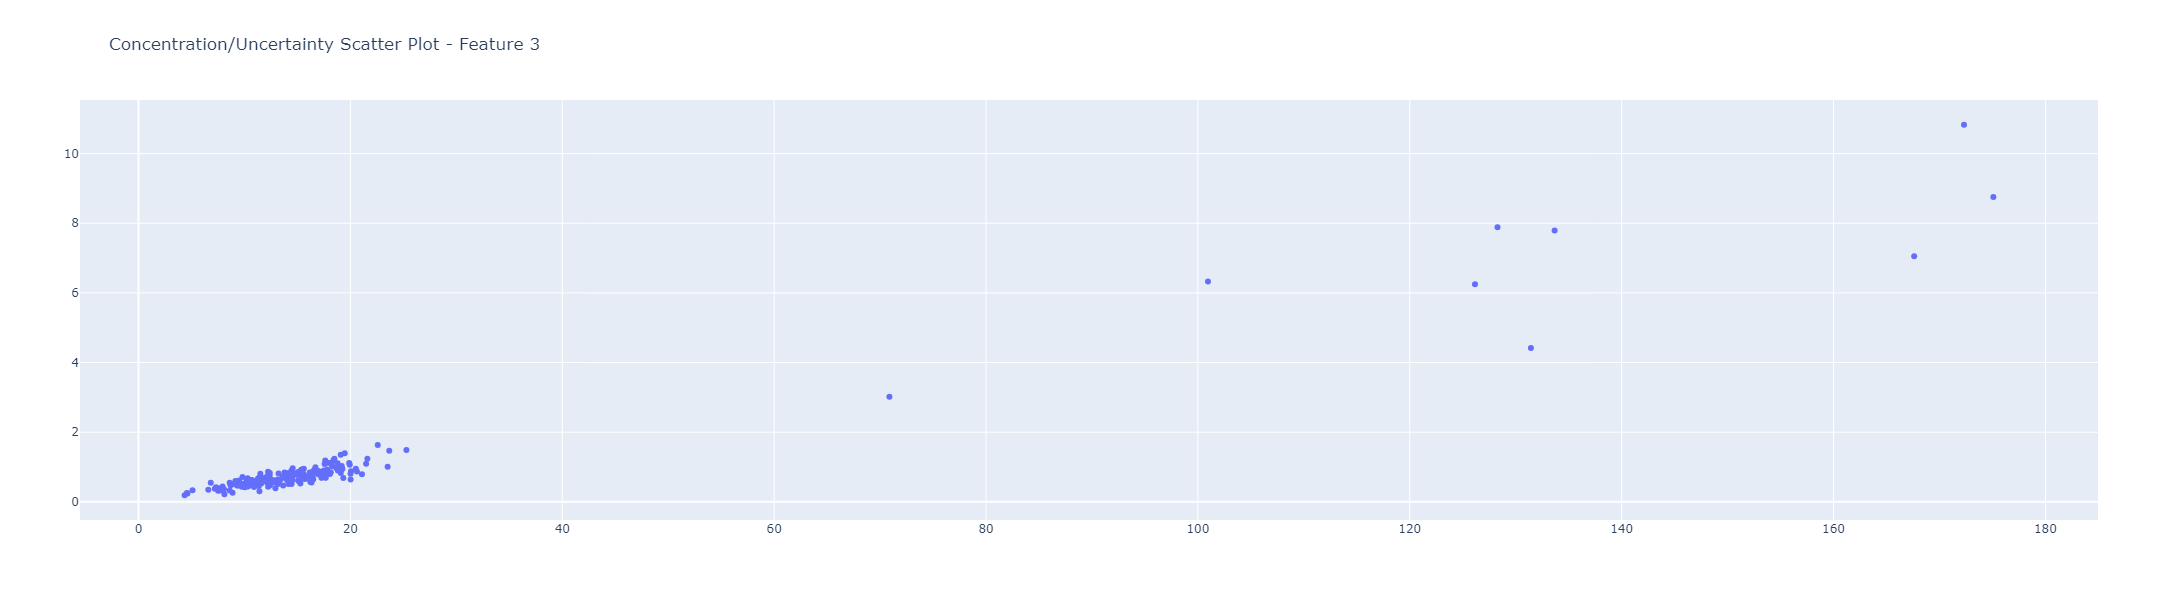

In [47]:
# Concentration / Uncertainty Scatter plot for specific feature, feature/column specified by index
data_handler.plot_data_uncertainty(feature_idx=2)

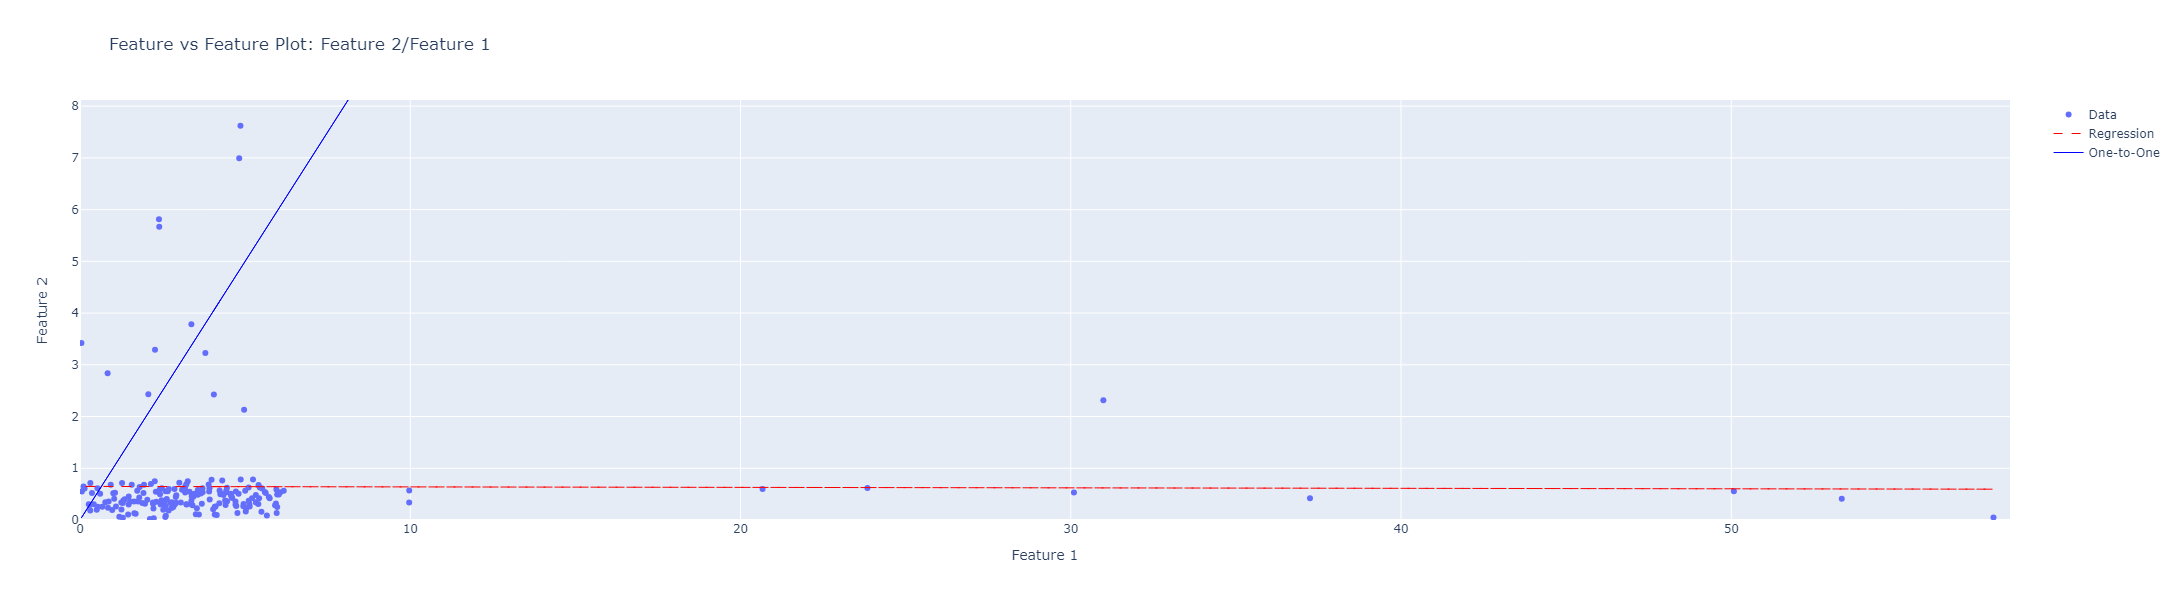

In [48]:
# Species Concentration plot comparing features, features/columns specified by index
data_handler.plot_feature_data(x_idx=0, y_idx=1)

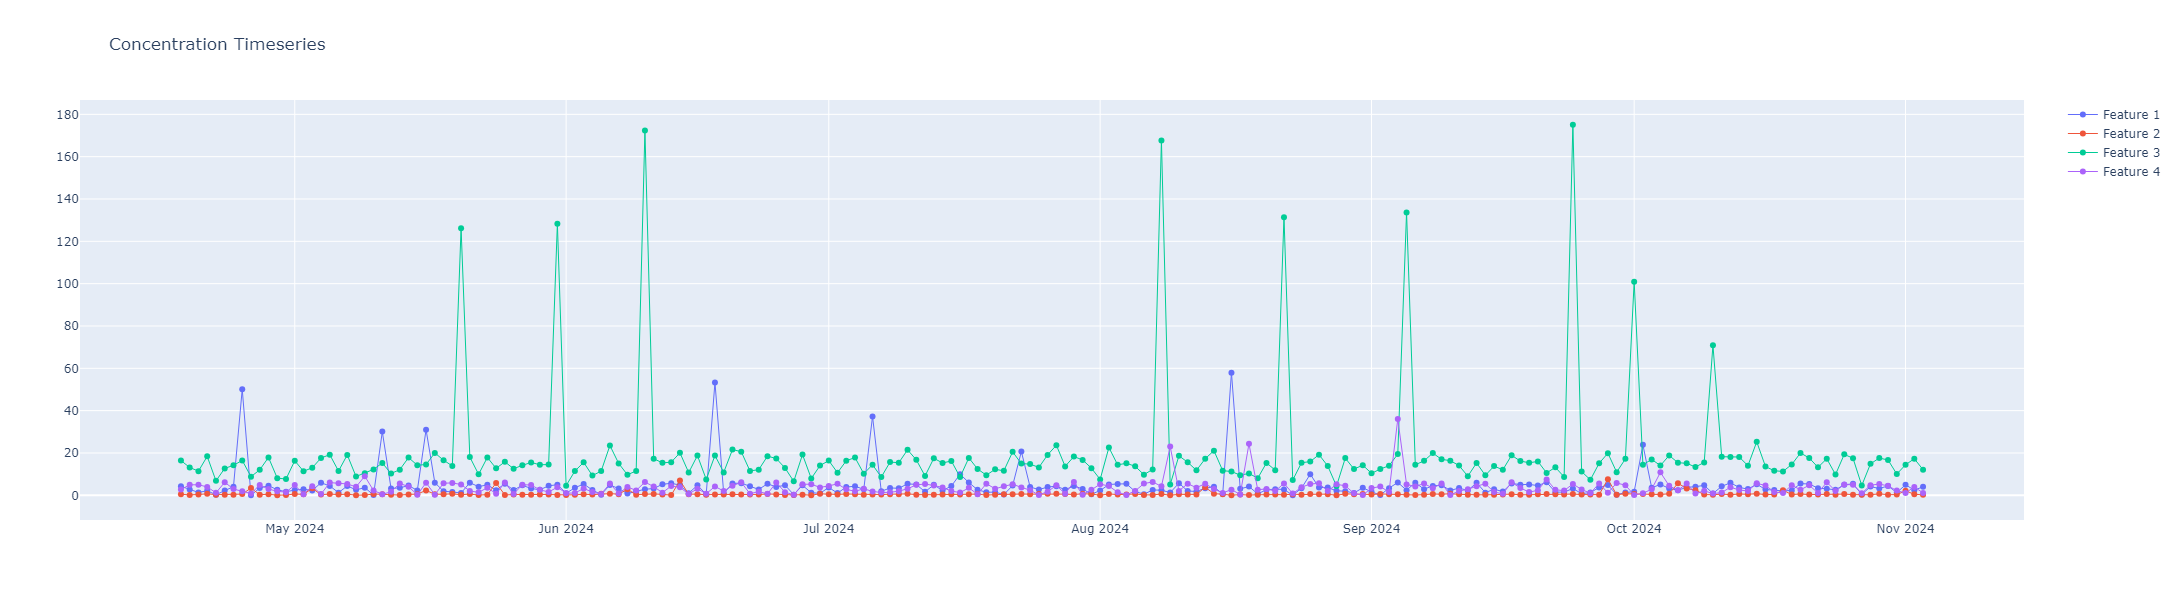

In [49]:
# Species Timeseries, a single or list of features/columns specified by index
data_handler.plot_feature_timeseries(feature_selection=[0, 1, 2, 3])

In [50]:
%%time
# Training multiple models, optional parameters are commented out.
sa_models = BatchSA(V=V, U=U, factors=factors, models=models, method=method, seed=seed, max_iter=max_iterations,
                    init_method=init_method, init_norm=init_norm,
                    converge_delta=converge_delta, converge_n=converge_n, 
                    parallel=parallel, optimized=optimized,
                    verbose=verbose
                   )
_ = sa_models.train()

18-Apr-24 15:23:27 - Model: 1, Q(true): 172648.0478, Q(robust): 37361.7738, Seed: 8925, Converged: True, Steps: 2983/20000
18-Apr-24 15:23:27 - Model: 2, Q(true): 172629.9337, Q(robust): 37351.8229, Seed: 77395, Converged: True, Steps: 1394/20000
18-Apr-24 15:23:27 - Model: 3, Q(true): 172643.3341, Q(robust): 37361.2594, Seed: 65457, Converged: True, Steps: 3118/20000
18-Apr-24 15:23:27 - Model: 4, Q(true): 172691.925, Q(robust): 37411.1852, Seed: 43887, Converged: True, Steps: 4548/20000
18-Apr-24 15:23:27 - Model: 5, Q(true): 172640.9236, Q(robust): 37358.2828, Seed: 43301, Converged: True, Steps: 1662/20000
18-Apr-24 15:23:27 - Model: 6, Q(true): 172646.9538, Q(robust): 37359.1246, Seed: 85859, Converged: True, Steps: 1582/20000
18-Apr-24 15:23:27 - Model: 7, Q(true): 172631.8874, Q(robust): 37349.38, Seed: 8594, Converged: True, Steps: 1465/20000
18-Apr-24 15:23:27 - Model: 8, Q(true): 172633.9792, Q(robust): 37354.7512, Seed: 69736, Converged: True, Steps: 2163/20000
18-Apr-24 15:

CPU times: total: 141 ms
Wall time: 7.53 s


#### Train Model

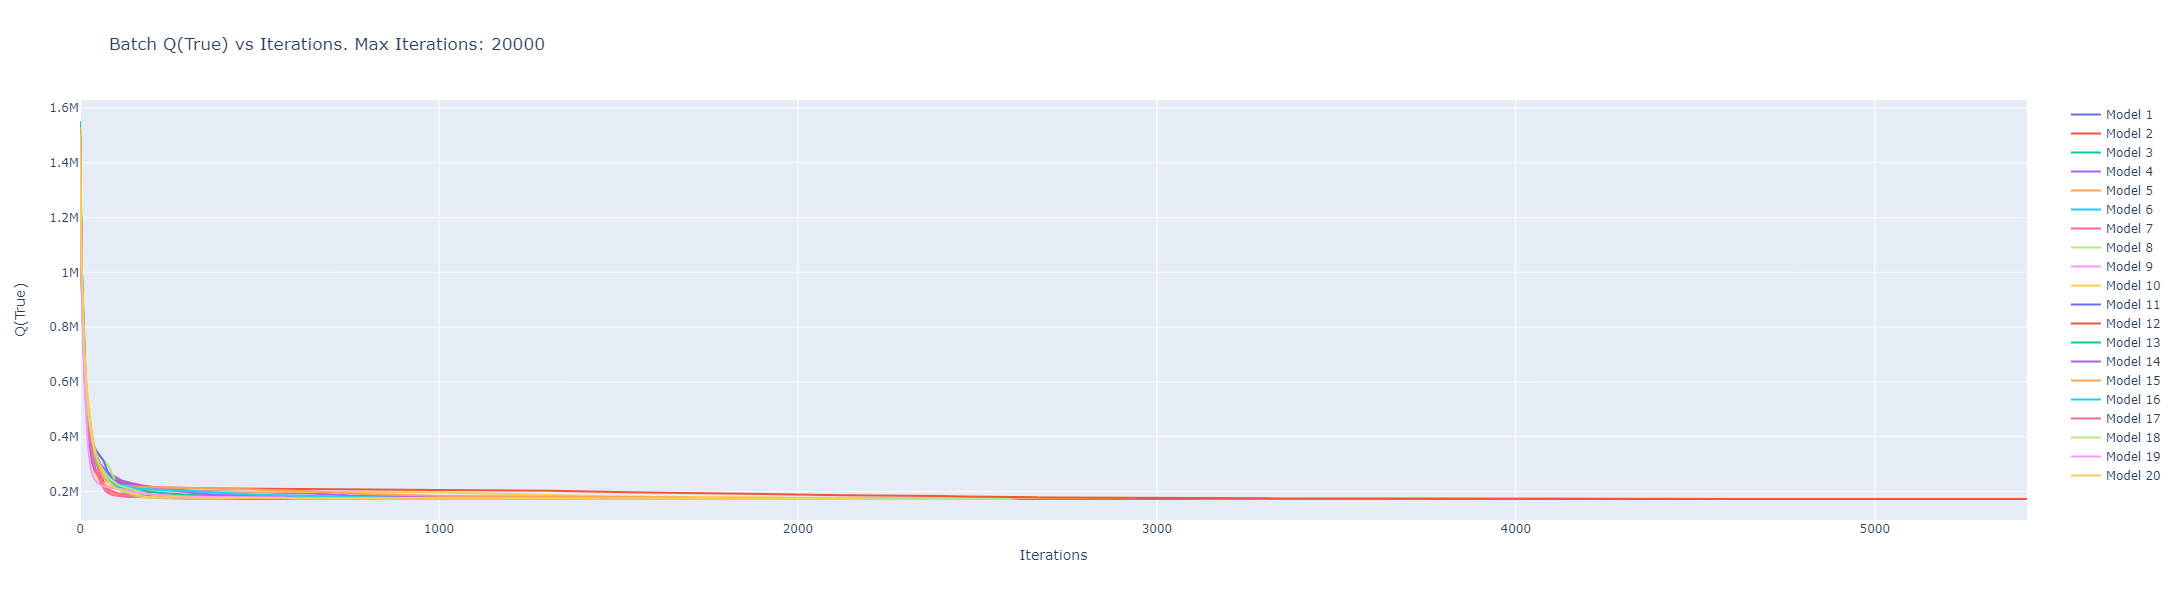

In [13]:
# Perform batch model analysis
batch_analysis = BatchAnalysis(batch_sa=sa_models)
# Plot the loss of the models over iterations
batch_analysis.plot_loss()

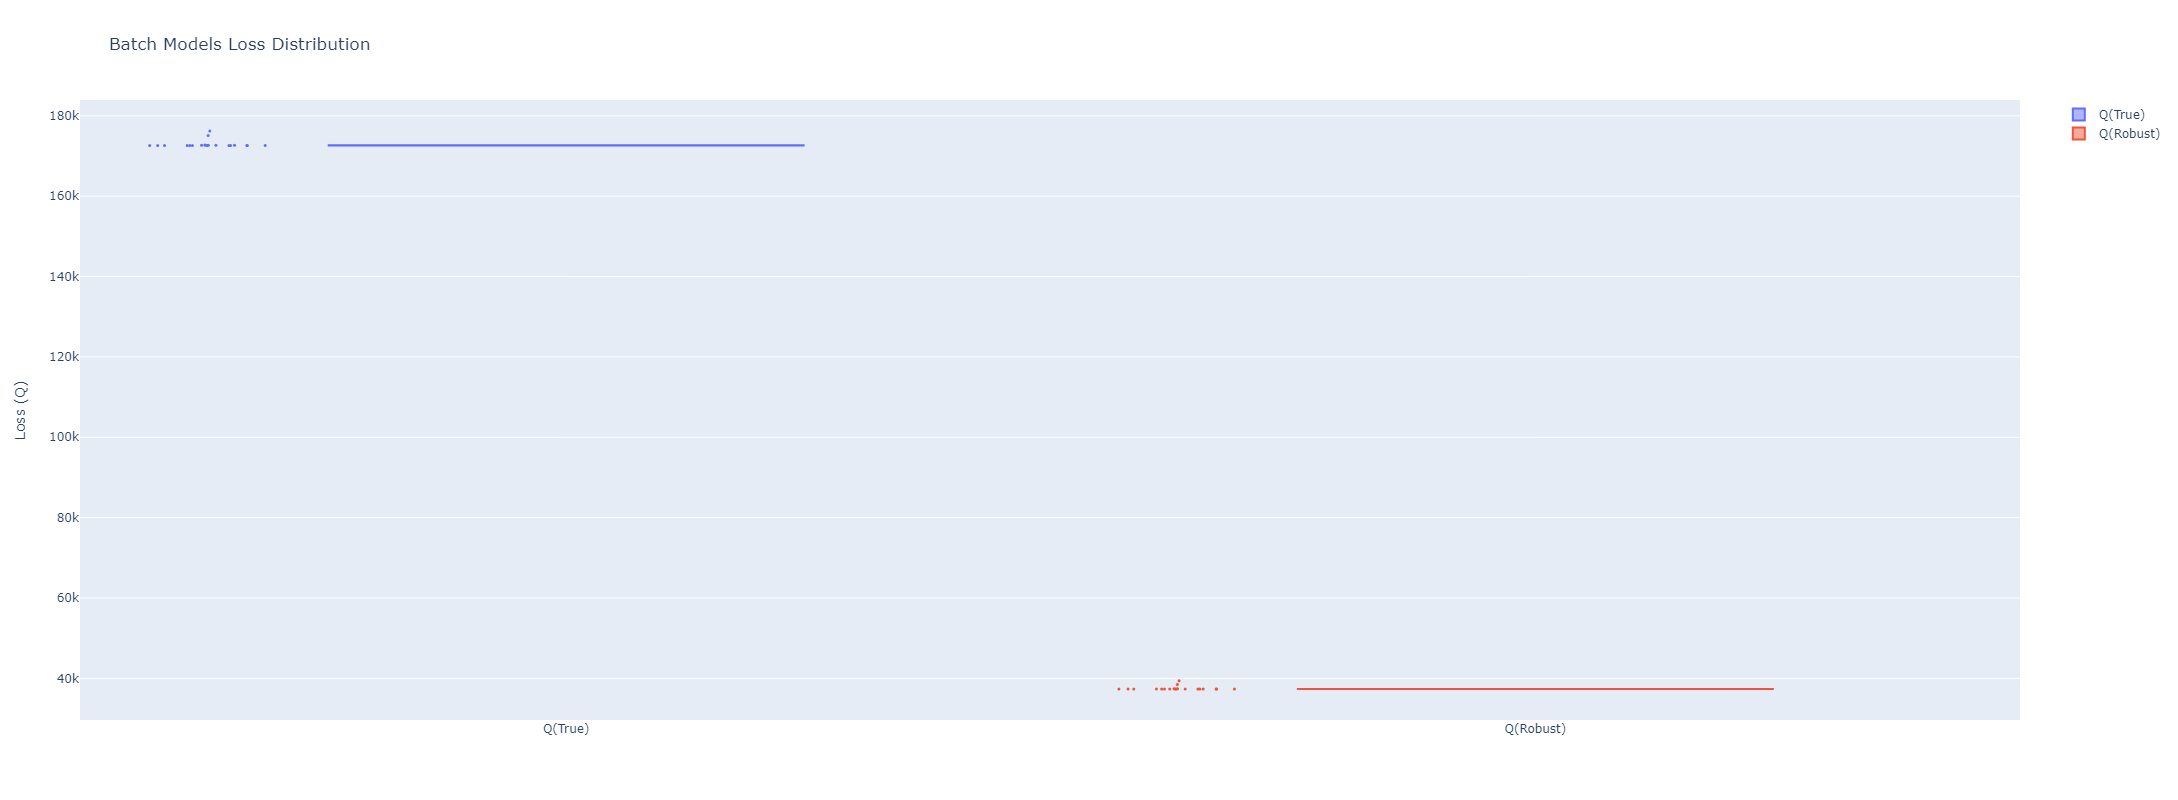

In [14]:
# Plot the loss distribution for the batch models
batch_analysis.plot_loss_distribution()

### Compare to Synthetic Data

Compare the set of batch models to the original synthetic factor data.


In [15]:
simulator.compare(batch_sa=sa_models)

Calculating correlation between factors from each model: 100%|█████████████████████████| 20/20 [00:01<00:00, 18.39it/s]


Number of permutations for 6 factors: 720


Calculating average correlation for all permutations for each model: 100%|█████████████| 20/20 [02:08<00:00,  6.42s/it]


R2 - Model: 13, Best permutations: ['Factor 4', 'Factor 2', 'Factor 5', 'Factor 3', 'Factor 1', 'Factor 6'], Average R2: 0.9990576387588432, 
Profile R2 Avg: 0.9996301569386699, Contribution R2 Avg: 0.9984888242204321, WH R2 Avg: 0.9990539351174279
Profile R2: [0.9993744096490897, 0.9996598418396637, 0.9997116018418224, 0.9997950372816755, 0.99958984376076, 0.9996502072590083], 
Contribution R2: [0.9986406907166838, 0.9986583209951811, 0.9990808048778281, 0.9968997902865527, 0.9985831260083637, 0.9990702124379836], 
WH R2: [0.9988014056213699, 0.998993963218467, 0.9993484710253362, 0.9988289027090426, 0.9989742990616333, 0.9993765690687179]

Base Q(true): 479.5337742286873, SA Model 13 Q(true): 172645.18400787472


Calculating correlation between factors from each model: 100%|████████████████████████| 20/20 [00:00<00:00, 345.62it/s]


Number of permutations for 6 factors: 720


Calculating average correlation for all permutations for each model: 100%|█████████████| 20/20 [00:08<00:00,  2.29it/s]

R2 - Model: 7, Best permutations: ['Factor 3', 'Factor 1', 'Factor 2', 'Factor 5', 'Factor 6', 'Factor 4'], Average R2: 0.9990377194302088, 
Profile R2 Avg: 0.9996162412728831, Contribution R2 Avg: 0.9984674815073801, WH R2 Avg: 0.9990294355103634
Profile R2: [0.9993354009319996, 0.9995877289455722, 0.9997159124385456, 0.9998319681902341, 0.999562677788088, 0.9996637593428587], 
Contribution R2: [0.9986582804774533, 0.998656109594832, 0.9990787325320726, 0.9968472113966816, 0.9984986694162632, 0.9990658856269775], 
WH R2: [0.9987852038644872, 0.9989561681567594, 0.9993448342013709, 0.9988100806654472, 0.9988982548306089, 0.9993820713435071]

Base Q(true): 479.5337742286873, SA Model 7 Q(true): 172631.88735124003


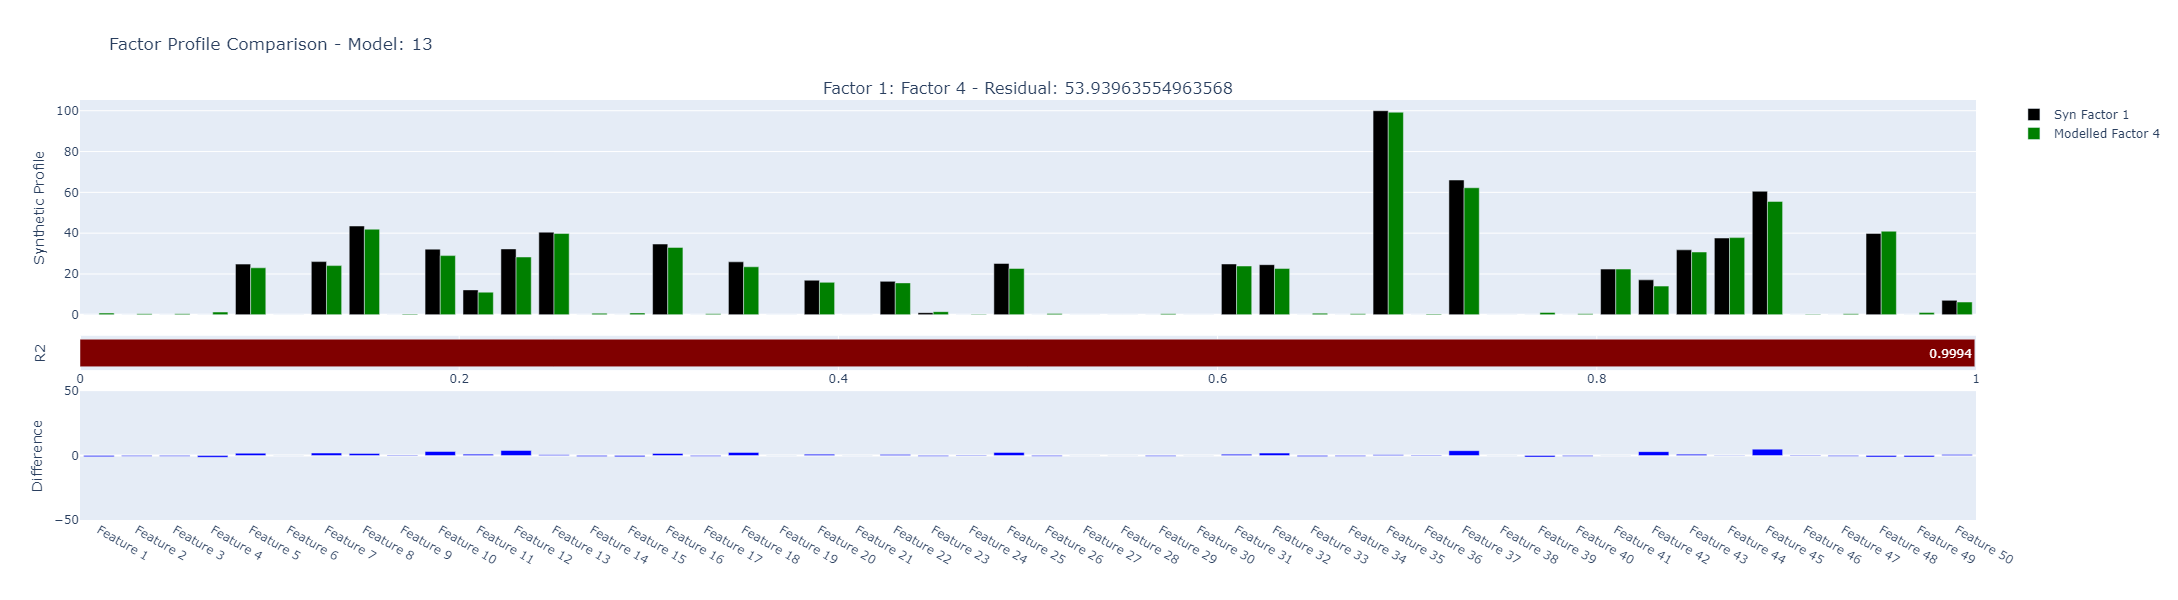

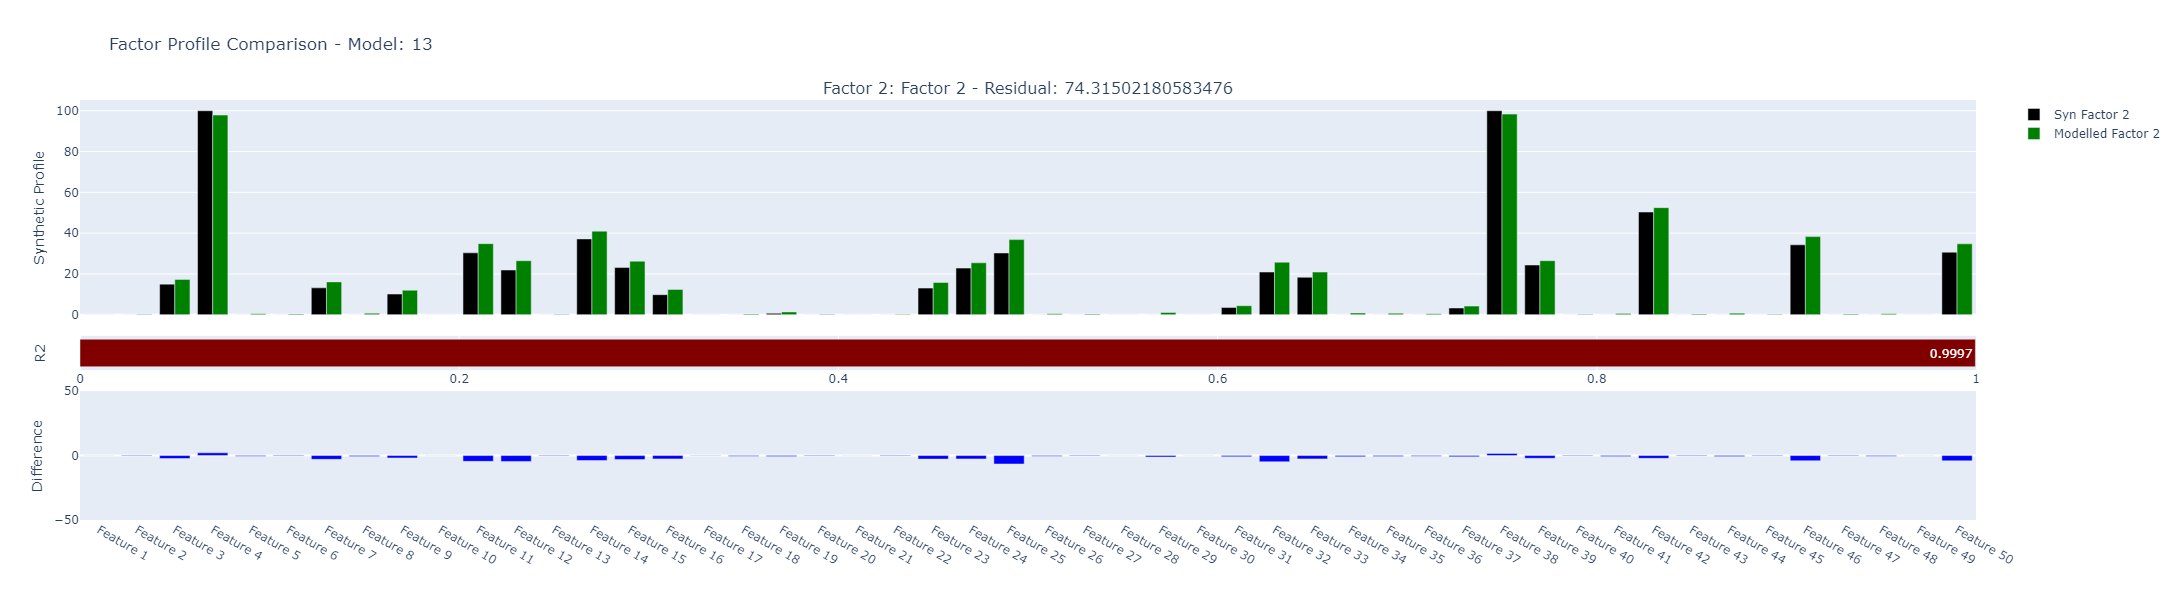

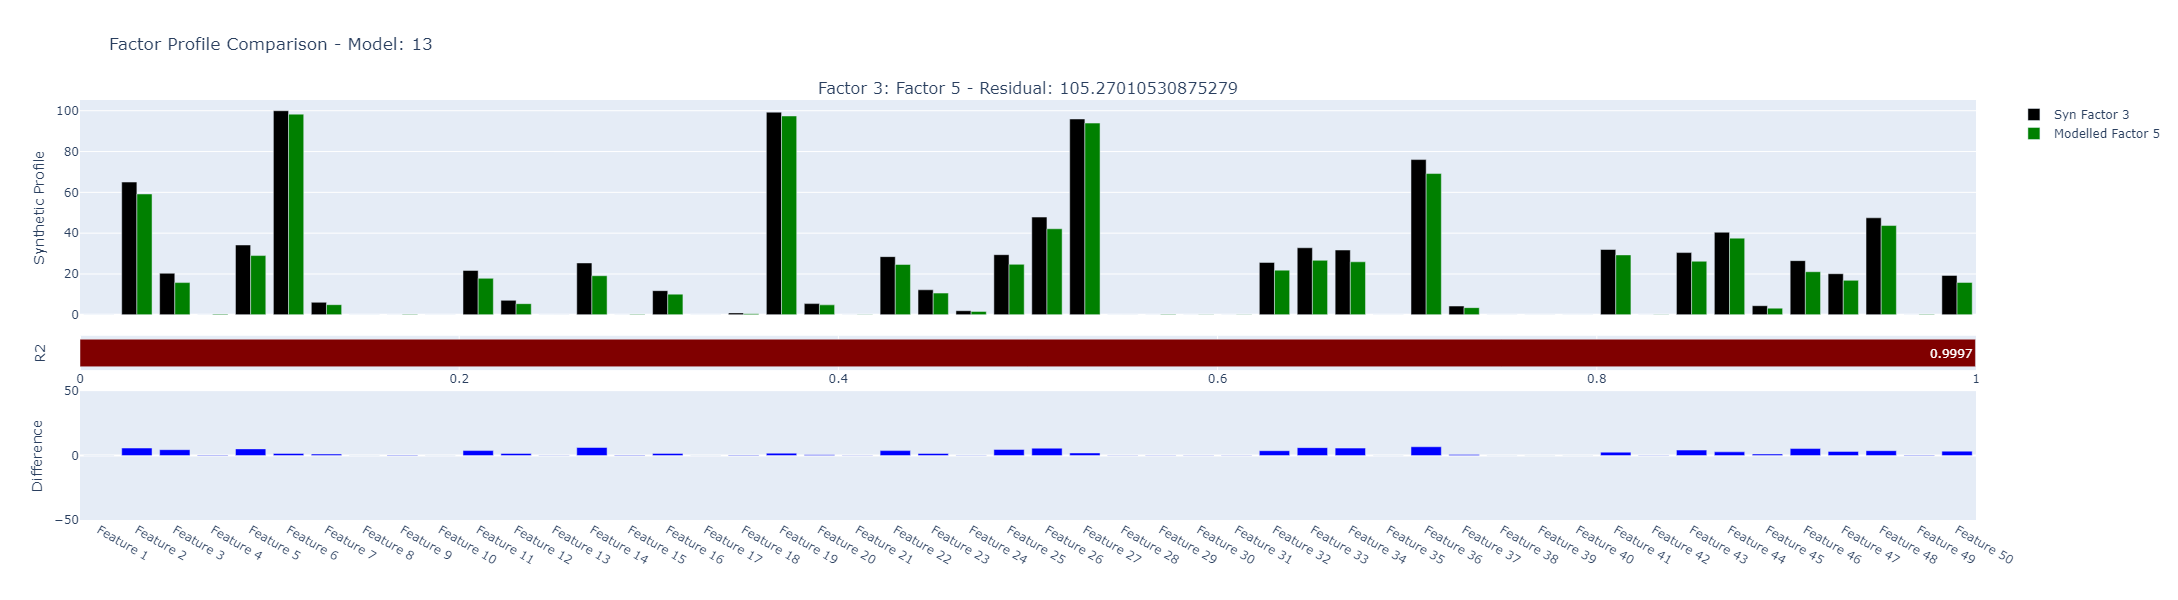

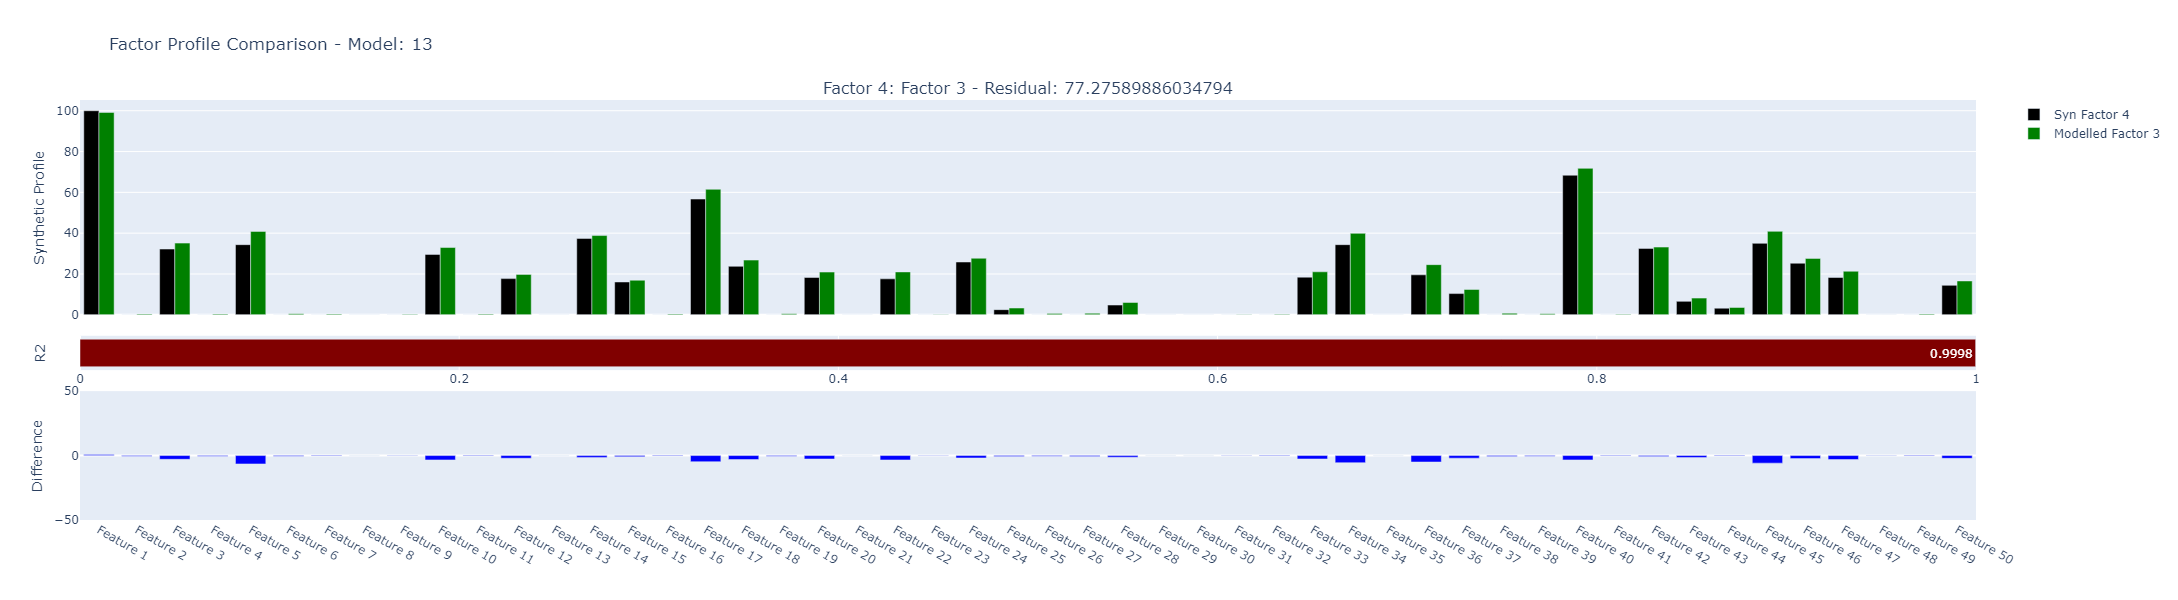

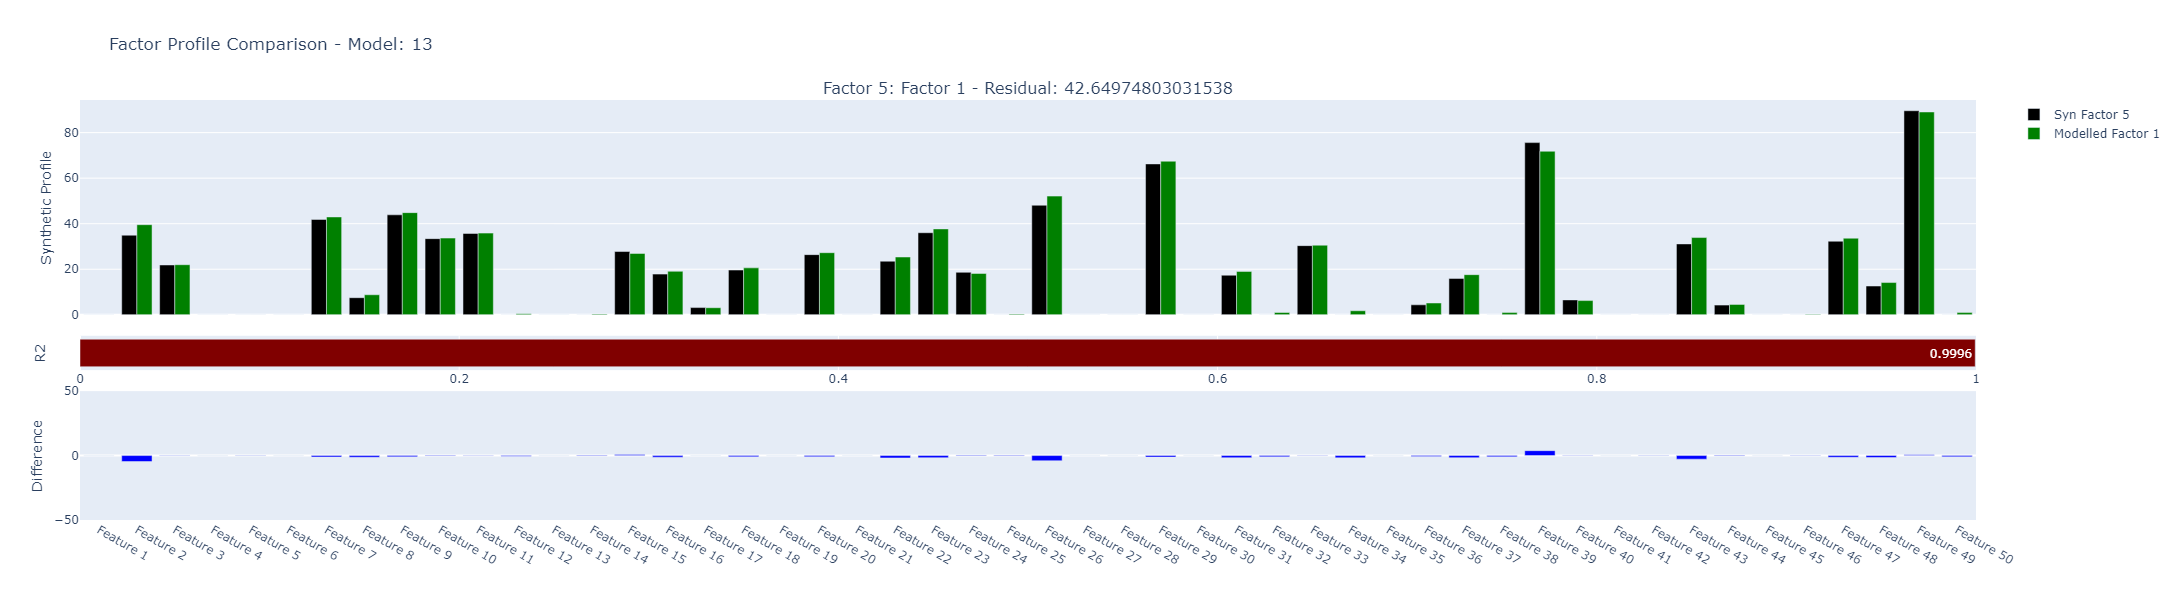

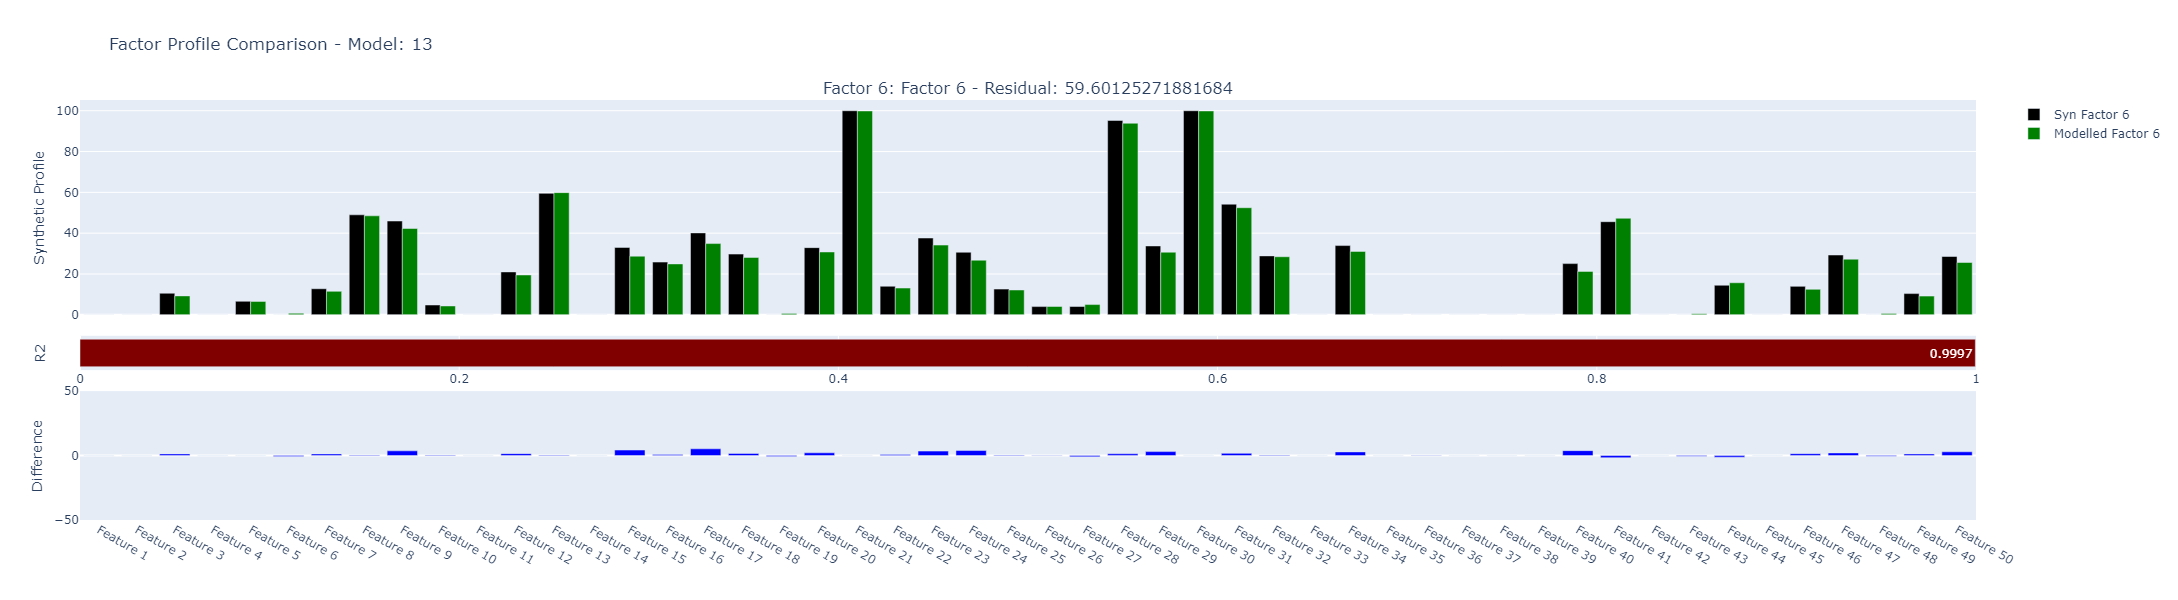

In [16]:
simulator.plot_comparison()

In [30]:
# # Get best mapping of the most optimal (by loss)
# simulator.compare(batch_sa=sa_models, selected_model=[sa_models.best_model])
# # Plot those mapping results
# simulator.plot_comparison(optimal=True)

In [18]:
# Selet the highest correlated model
best_model = simulator.factor_compare.best_model
sa_model = sa_models.results[best_model]
best_model

12

In [19]:
# Initialize the Model Analysis module
model_analysis = ModelAnalysis(datahandler=data_handler, model=sa_model, selected_model=best_model)

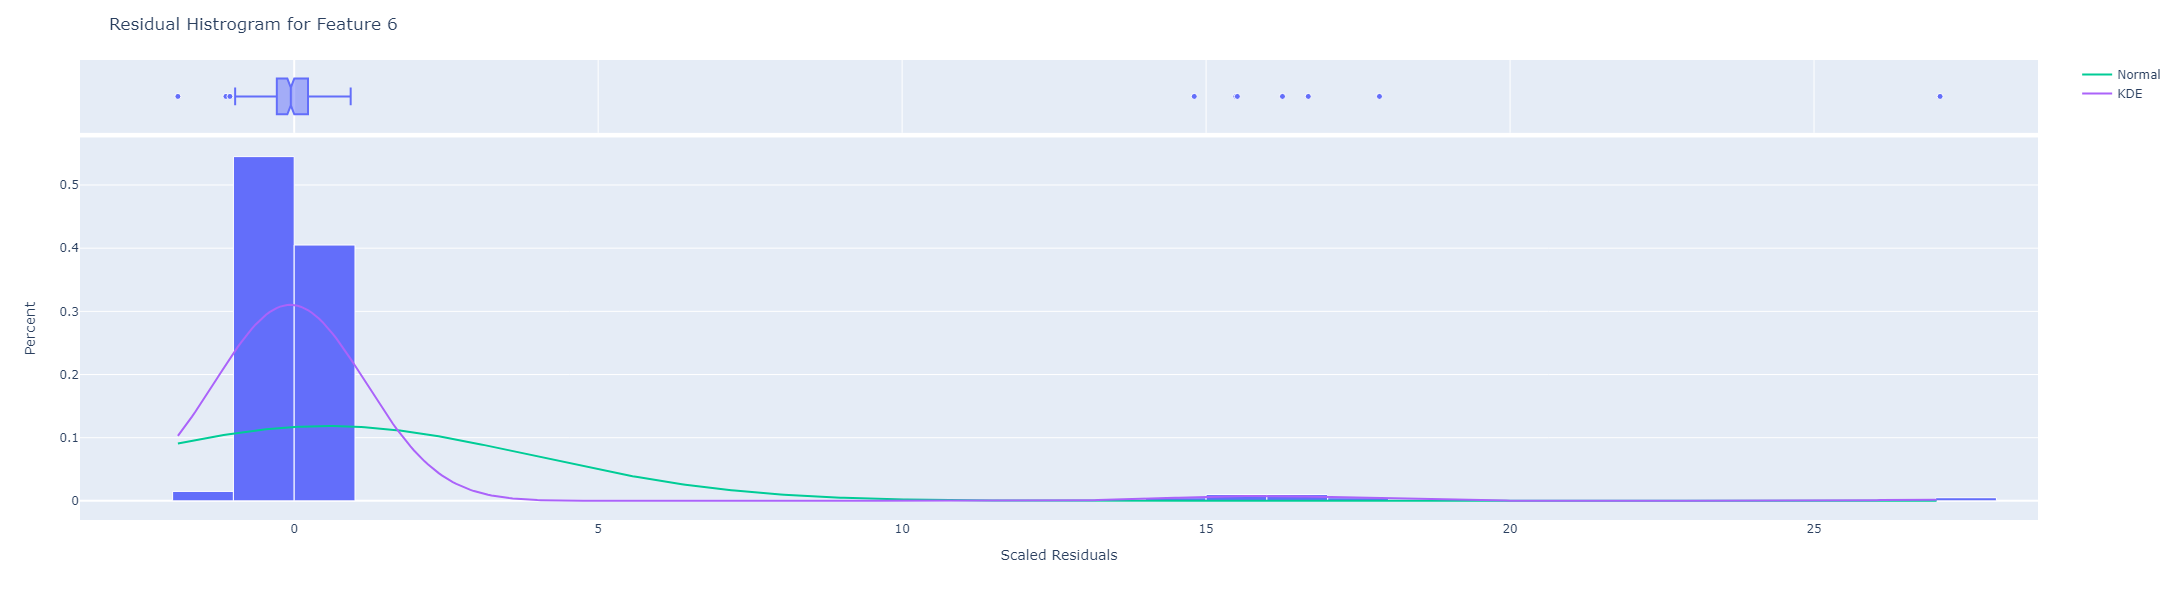

In [20]:
# Residual Analysis shows the scaled residual histogram, along with metrics and distribution curves. The abs_threshold parameter specifies the condition for the returned values of the function call as those residuals which exceed the absolute value of that threshold.
abs_threshold = 3.0
threshold_residuals = model_analysis.plot_residual_histogram(feature_idx=5, abs_threshold=abs_threshold)

In [21]:
print(f"List of Absolute Scaled Residual Greather than: {abs_threshold}. Count: {threshold_residuals.shape[0]}")
threshold_residuals

List of Absolute Scaled Residual Greather than: 3.0. Count: 7


Feature 6   datetime
58   16.256466 2024-06-15
63   15.488918 2024-06-20
67   27.073717 2024-06-24
87   14.805138 2024-07-14
131  17.851701 2024-08-27
133  16.680735 2024-08-29
165  15.513917 2024-09-30

In [22]:
# The model output statistics for the estimated V, including SE: Standard Error metrics, and 3 normal distribution tests of the residuals (KS Normal is used in PMF5)
model_analysis.calculate_statistics()
model_analysis.statistics

Features Category        r2  Intercept  Intercept SE     Slope  \
0    Feature 1   Strong  0.118122   2.838364      0.128568  0.075021   
1    Feature 2   Strong  0.076339   0.382084      0.014621  0.049316   
2    Feature 3   Strong  0.024355  13.813385      0.344903  0.023497   
3    Feature 4   Strong  0.200756   2.241227      0.165010  0.226941   
4    Feature 5   Strong  0.123868  13.343673      0.360882  0.043290   
5    Feature 6   Strong  0.158403   2.222128      0.115051  0.094317   
6    Feature 7   Strong  0.071547   8.333314      0.236799  0.042198   
7    Feature 8   Strong  0.045822   3.844828      0.132078  0.042572   
8    Feature 9   Strong  0.059652  10.674128      0.350570  0.039304   
9   Feature 10   Strong  0.055062  13.492909      0.367486  0.026957   
10  Feature 11   Strong  0.081576  13.592229      0.365035  0.036120   
11  Feature 12   Strong  0.043519   9.640348      0.236826  0.026186   
12  Feature 13   Strong  0.099494   7.504438      0.259432  0.049604   
13  Feature 14   Strong  0.064252  13.014594      0.404330  0.041282   
14  Feature 15   Strong  0.008569  10.963139      0.289239  0.012916   
15  Feature 16   Strong  0.052760  11.409475      0.296222  0.030672   
16  Feature 17   Strong  0.089672   8.954891      0.277646  0.043260   
17  Feature 18   Strong  0.076007  15.168892      0.371276  0.038980   
18  Feature 19   Strong  0.105862   3.736391      0.204261  0.087314   
19  Feature 20   Strong  0.023320  15.927033      0.396823  0.019913   
20  Feature 21   Strong  0.107099   4.433054      0.204773  0.063951   
21  Feature 22   Strong  0.036391  18.278176      0.446009  0.023980   
22  Feature 23   Strong  0.070710  12.130169      0.343041  0.045390   
23  Feature 24   Strong  0.054125  10.834607      0.265376  0.028563   
24  Feature 25   Strong  0.033509  16.840046      0.466129  0.028372   
25  Feature 26   Strong  0.061032   4.493158      0.171727  0.060778   
26  Feature 27   Strong  0.111513   4.804120      0.241814  0.070448   
27  Feature 28   Strong  0.111334   4.866145      0.220282  0.079376   
28  Feature 29   Strong  0.096345   0.887904      0.036300  0.074102   
29  Feature 30   Strong  0.164014   0.736989      0.039930  0.149700   
30  Feature 31   Strong  0.079430   9.402840      0.281184  0.036371   
31  Feature 32   Strong  0.039380  17.864120      0.466921  0.027890   
32  Feature 33   Strong  0.064346  15.424929      0.407270  0.034904   
33  Feature 34   Strong  0.080415   6.025694      0.166542  0.042874   
34  Feature 35   Strong  0.162941   0.357857      0.019045  0.092302   
35  Feature 36   Strong  0.103347   3.975362      0.166121  0.071049   
36  Feature 37   Strong  0.117161   7.203789      0.273321  0.078399   
37  Feature 38   Strong  0.138150   2.706795      0.142585  0.079362   
38  Feature 39   Strong  0.134318   3.682631      0.207644  0.158625   
39  Feature 40   Strong  0.075541   7.363687      0.250771  0.053362   
40  Feature 41   Strong  0.050503   8.845254      0.278247  0.040097   
41  Feature 42   Strong  0.086443   6.833028      0.228664  0.056414   
42  Feature 43   Strong  0.065604   8.222508      0.261452  0.055176   
43  Feature 44   Strong  0.093743   7.800290      0.271283  0.075137   
44  Feature 45   Strong  0.126909   6.851839      0.231285  0.052593   
45  Feature 46   Strong  0.054201  13.070838      0.376092  0.043597   
46  Feature 47   Strong  0.030395  13.574781      0.353951  0.022267   
47  Feature 48   Strong  0.070843   7.878898      0.279755  0.045388   
48  Feature 49   Strong  0.148796   5.129316      0.247046  0.092053   
49  Feature 50   Strong  0.065517  13.090333      0.317653  0.033138   

    Slope SE        SE  SE Regression Anderson Normal Residual  \
0   0.014568  0.503057       1.539271                       No   
1   0.012191  0.069078       0.173473                       No   
2   0.010569  1.819866       3.874867                       No   
3   0.032180  0.231465       1.654453                       No   
4  

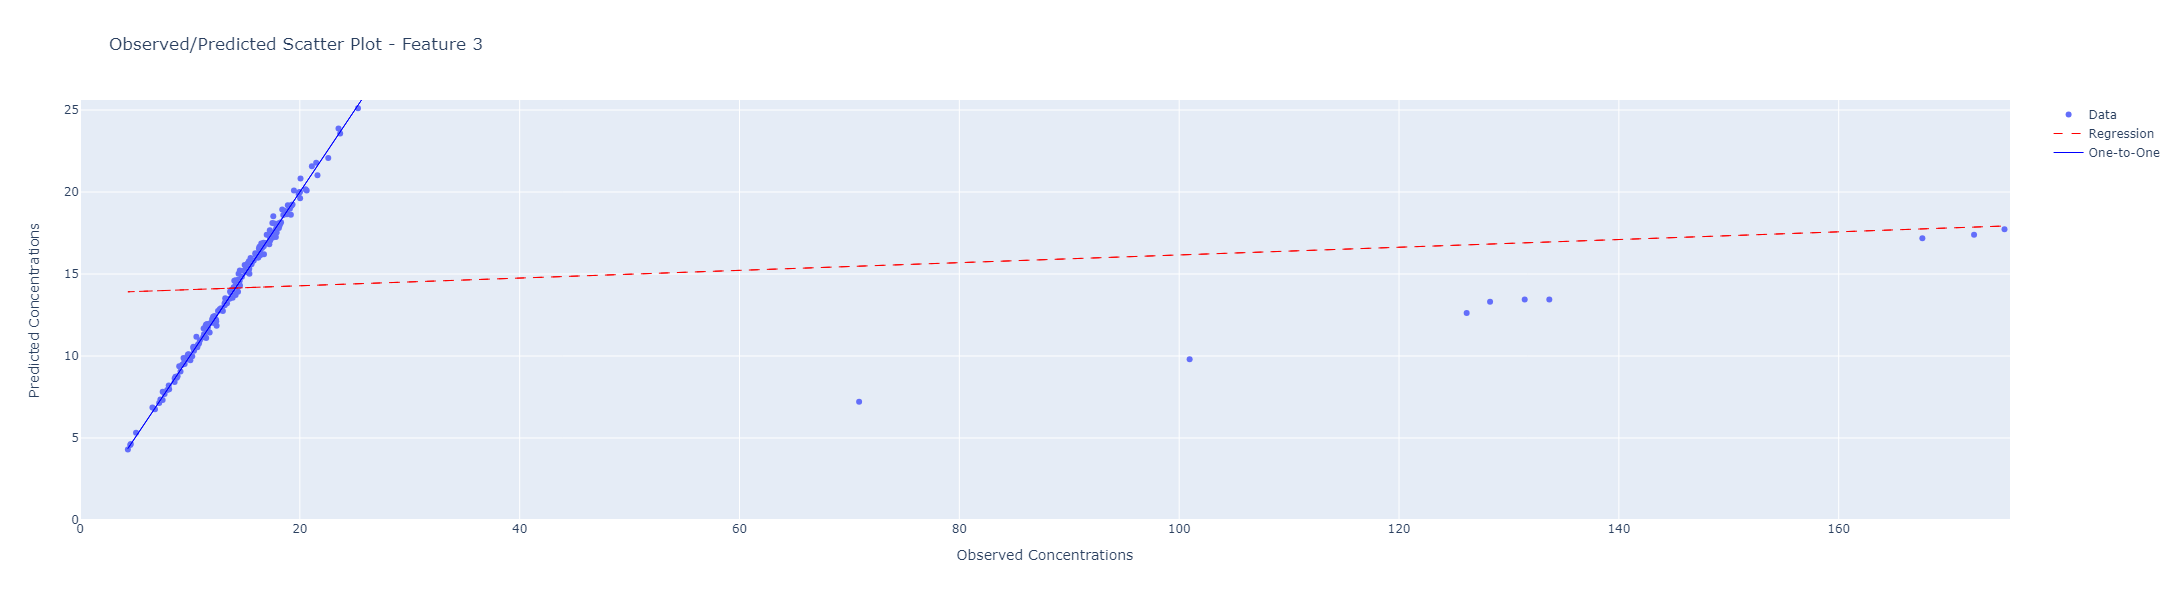

In [23]:
# Model feature observed vs predicted plot with regression and one-to-one lines. Feature/Column specified by index.
model_analysis.plot_estimated_observed(feature_idx=2)

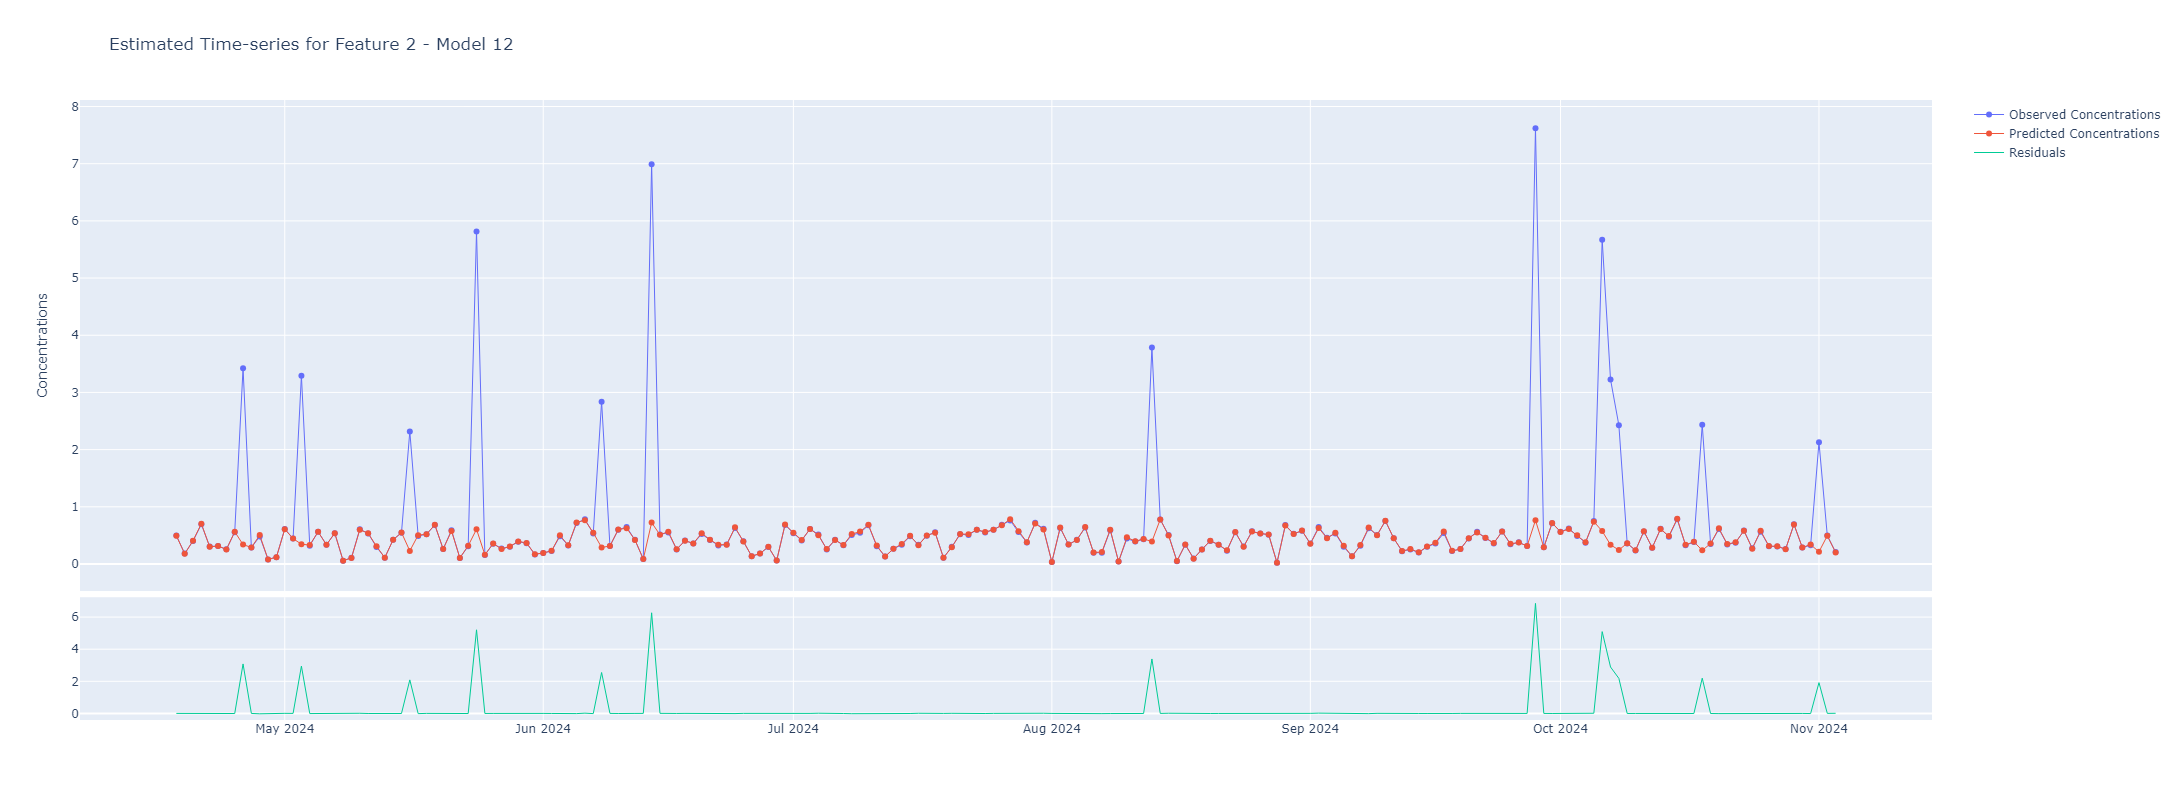

In [24]:
# Model feature timeseries analysis plot showing the observed vs predicted values of the feature, along with the residuals shown below. Feature/column specified by index.
model_analysis.plot_estimated_timeseries(feature_idx=1)

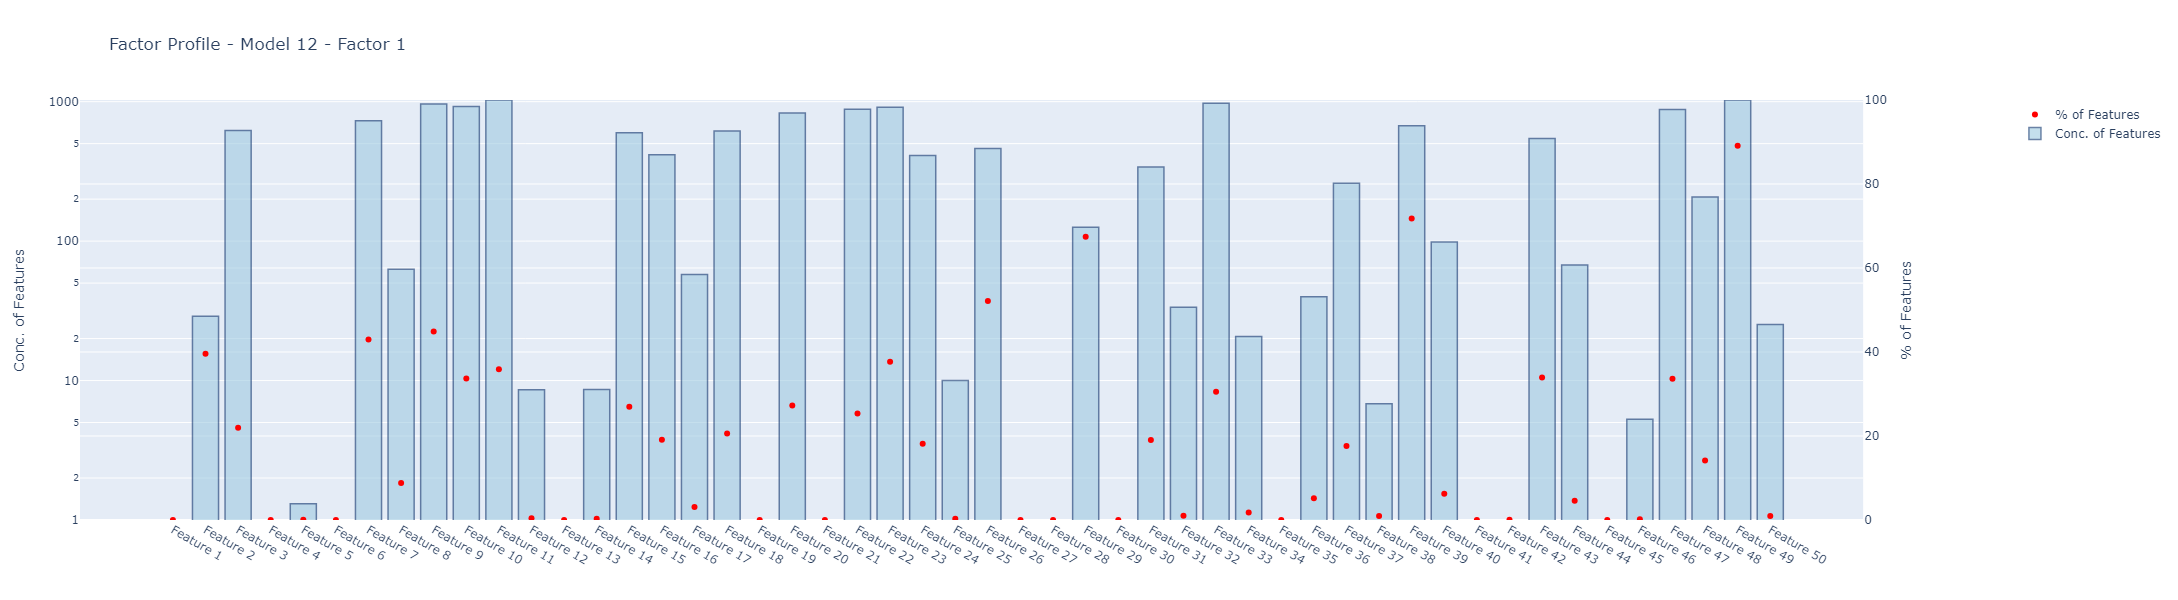

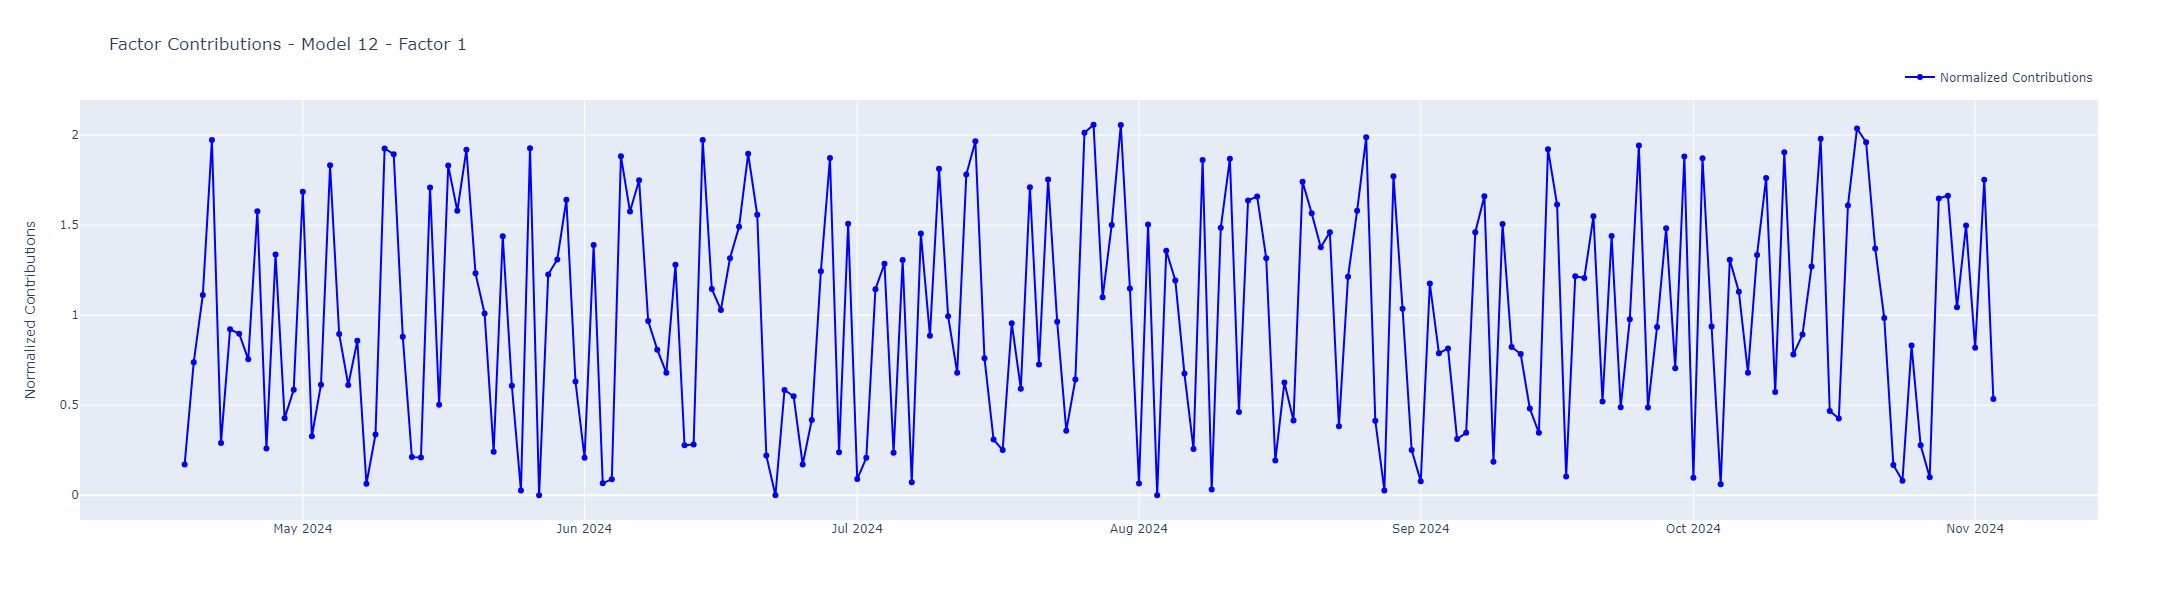

In [25]:
# Factor profile plot showing the factor sum of concentrations by feature (blue bars), the percentage of the feature as the red dot, and in the bottom plot the normalized contributions by date (values are resampled at a daily timestep for timeseries consistency).
# Factor specified by index.
model_analysis.plot_factor_profile(factor_idx=1)

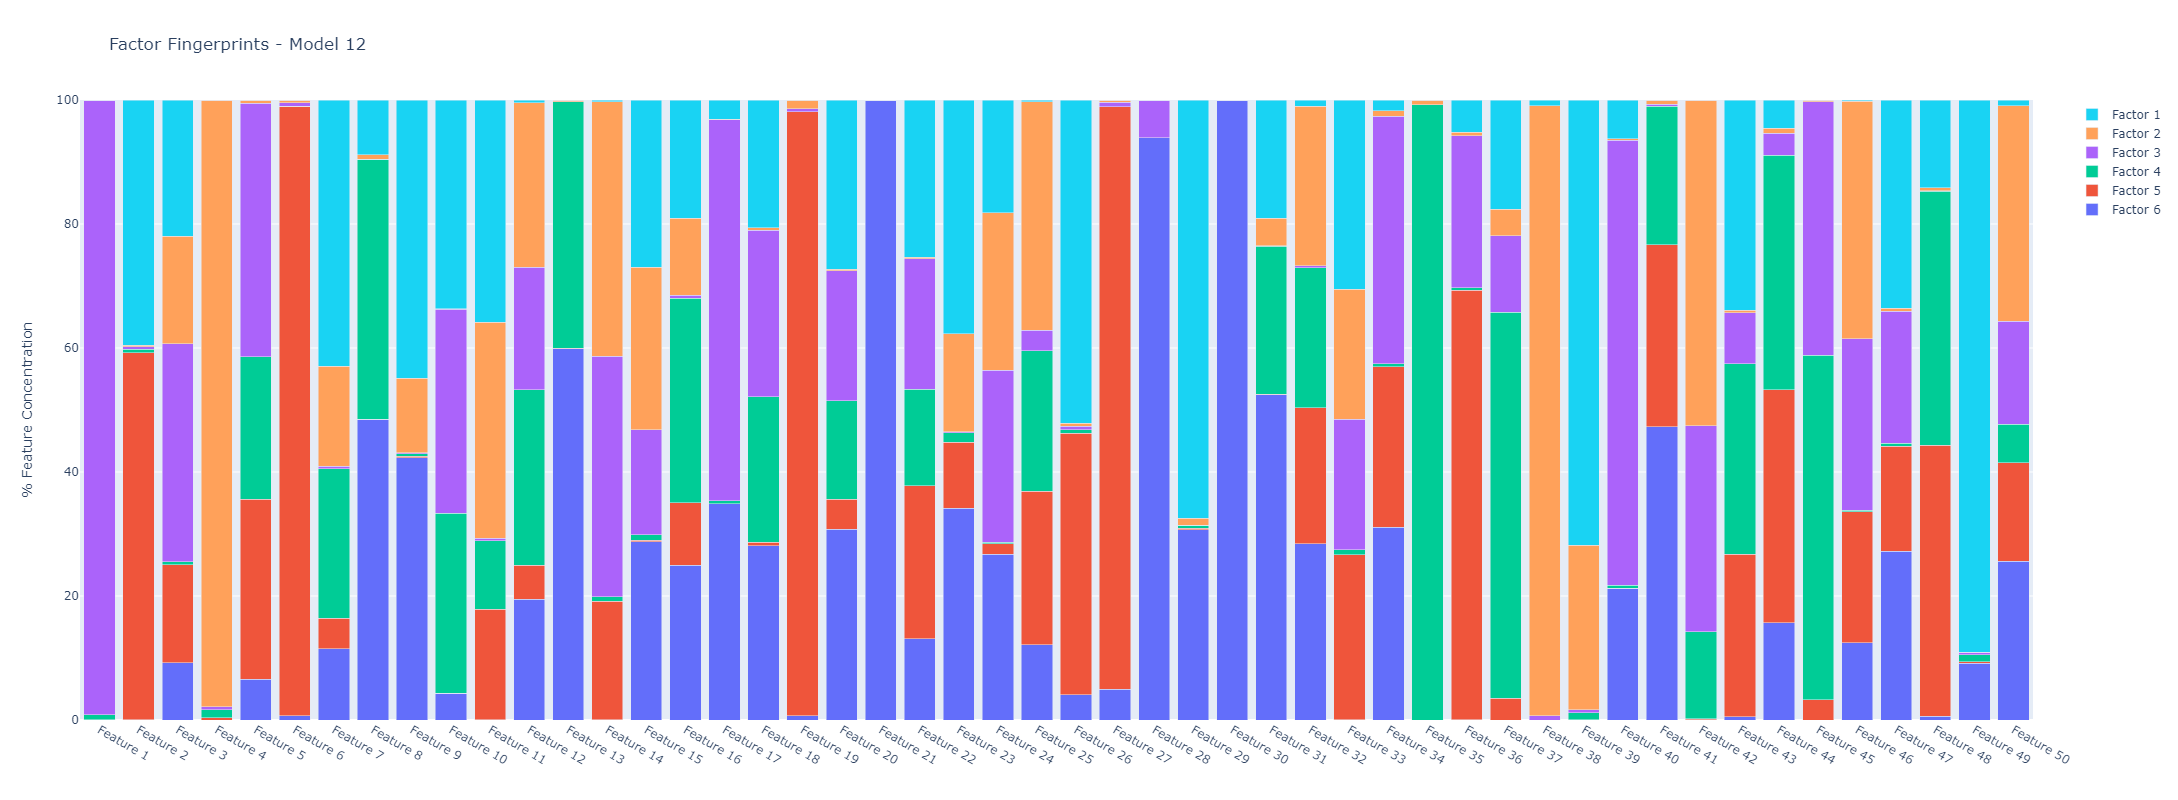

In [26]:
# Model factor fingerprint specifies the feature percentage of each factor.
model_analysis.plot_factor_fingerprints()

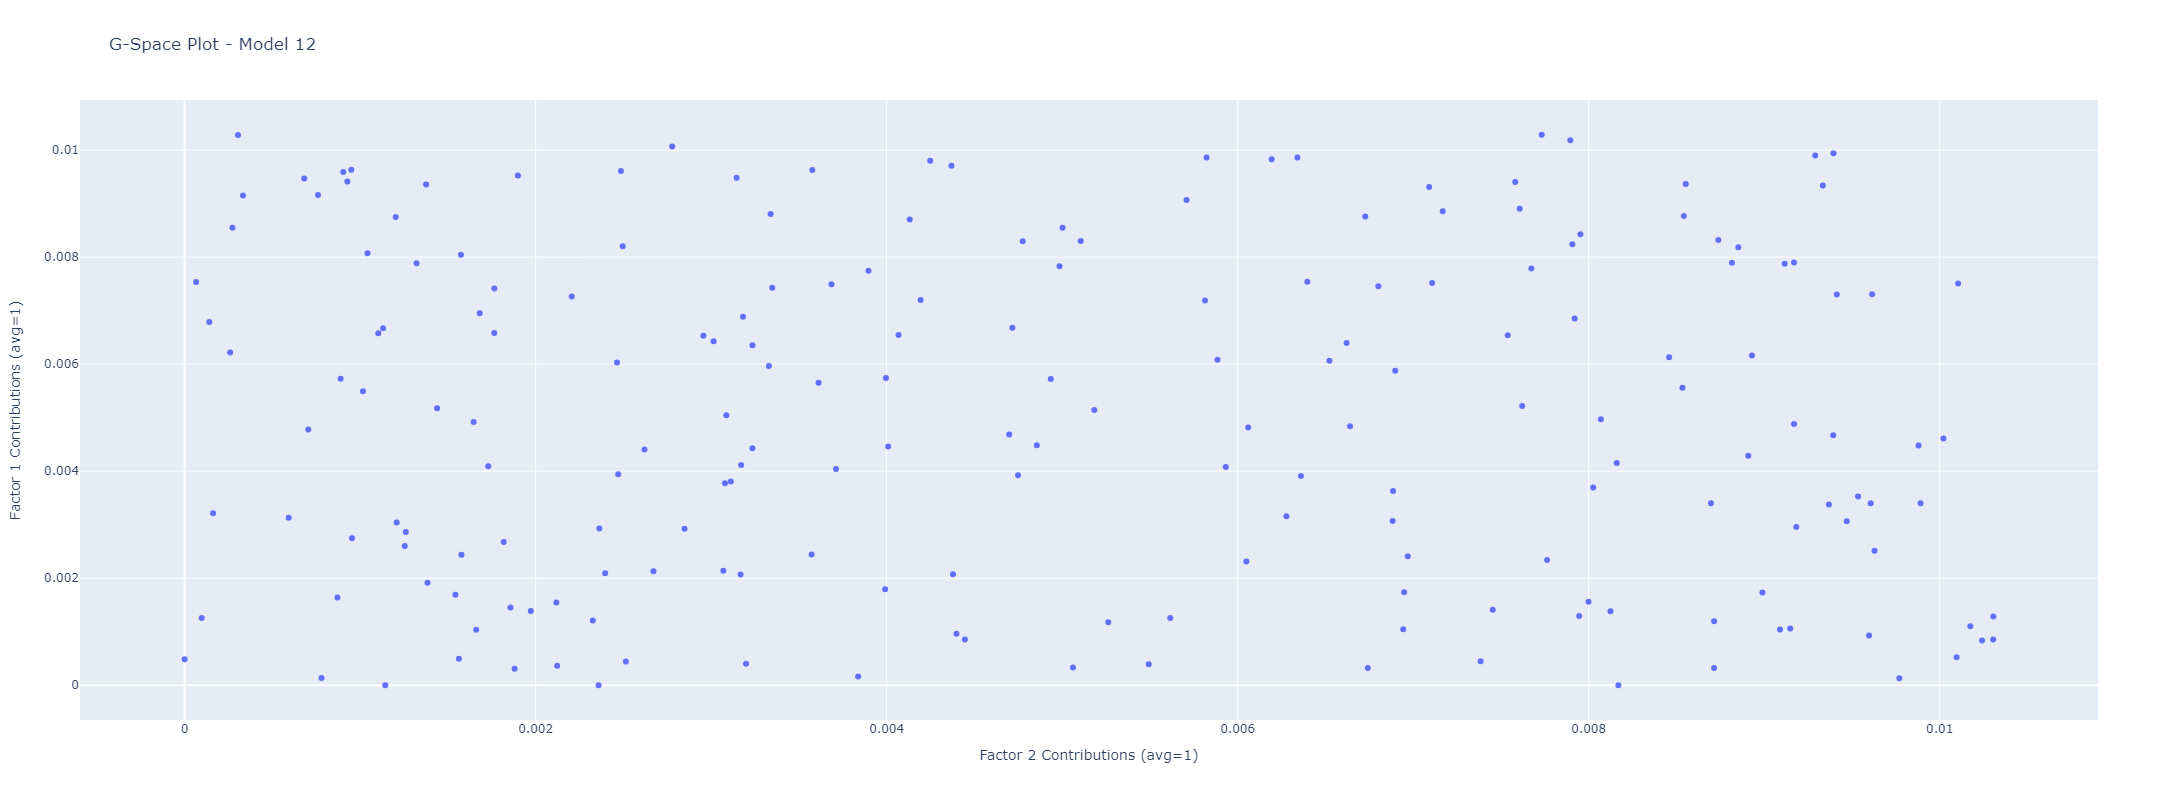

In [27]:
# Factor G-Space plot shows the normalized contributions of one factor vs another factor. Factor specified by index.
model_analysis.plot_g_space(factor_1=2, factor_2=1)

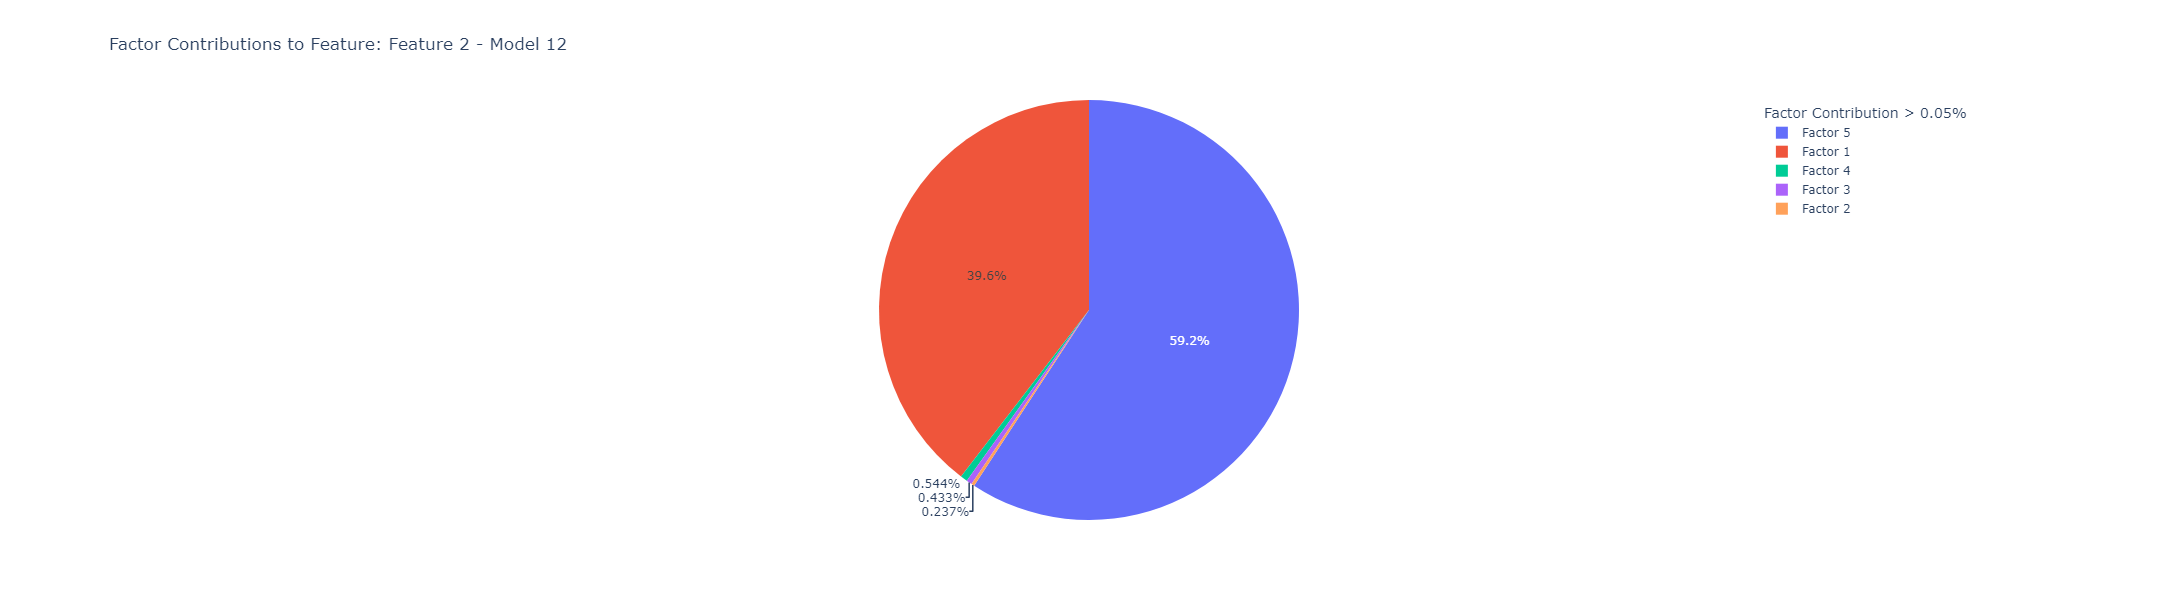

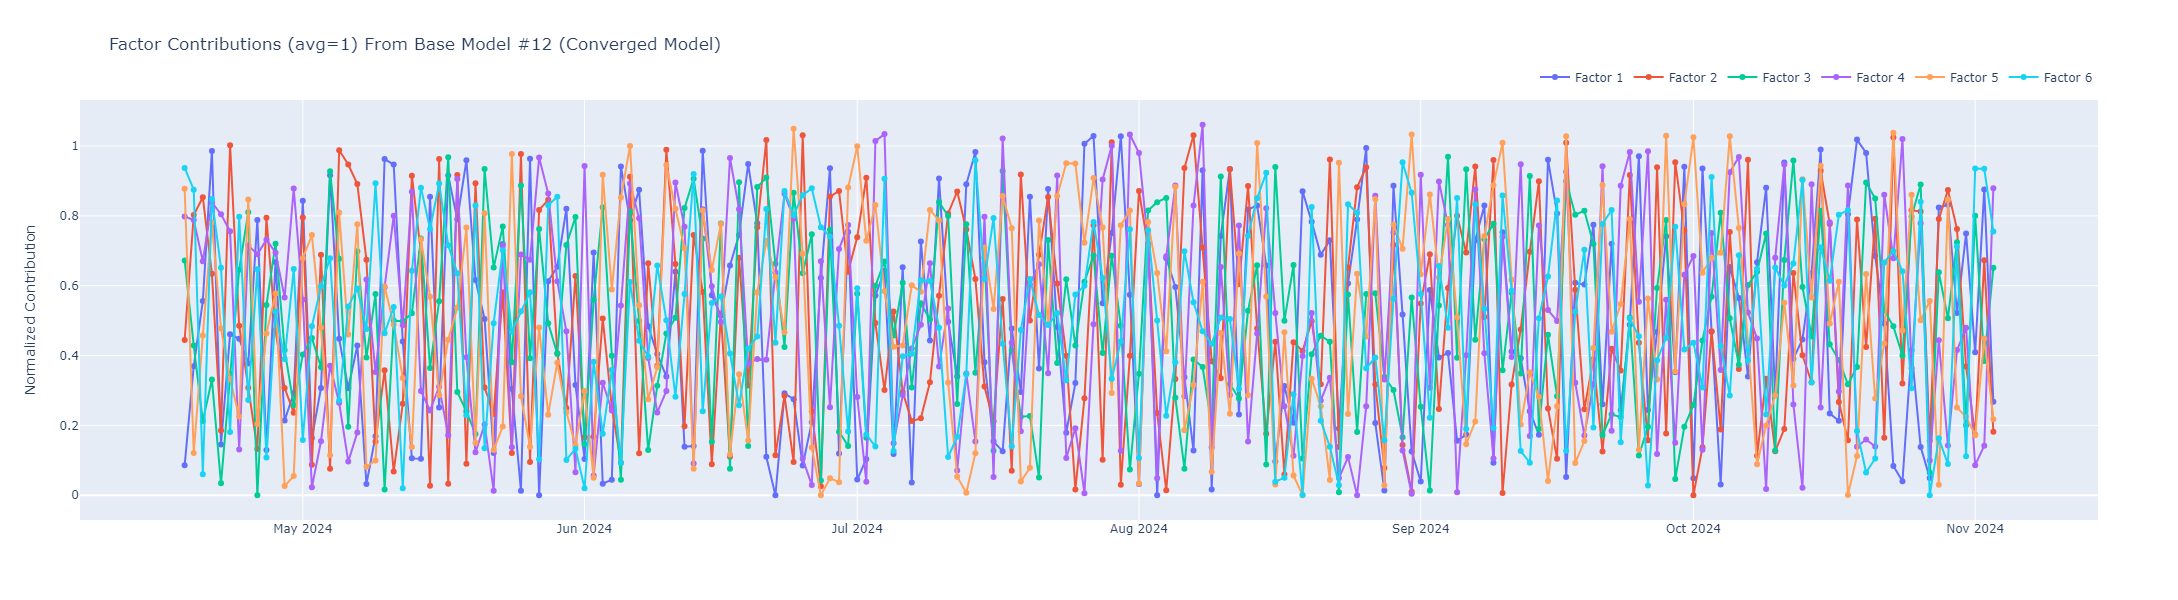

In [28]:
# Factor contribution pie chart shows the percentage of factor contributions for the specified feature, and the corresponding normalized contribution of each factor for that feature (bottom plot). Feature specified by index.
model_analysis.plot_factor_contributions(feature_idx=1)